In [1]:
import os
import time
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm import tqdm_notebook as tqdm
from PIL import Image

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision
import torchvision.transforms as transforms


mpl.rcParams['figure.dpi']= 300
mpl.rcParams["savefig.dpi"] = 300
%matplotlib inline
from resnet import resnet50
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\cwork\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "Faces/UTKFace/"
SAVE_PATH = "saving/"

def reload_data():
    age_list = []
    gender_list = []
    race_list = []
    datetime_list = []
    filename_list = []

    for filename in os.listdir(DATA_PATH):

        args = filename.split("_")

        if len(args)<4:
            age = int(args[0])
            gender = int(args[1])
            race = 4
            datetime = args[2].split(".")[0]
        else:
            age = int(args[0])
            gender = int(args[1])
            race = int(args[2])
            datetime = args[3].split(".")[0]

        age_list.append(age)
        gender_list.append(gender)
        race_list.append(race)
        datetime_list.append(datetime)
        filename_list.append(filename)


    d = {'age': age_list, 'gender': gender_list, 'race': race_list, 'datetime': datetime_list, 'filename': filename_list}
    return pd.DataFrame(data=d)
    
df = reload_data()

In [3]:
df["race"] = df["race"].replace( {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"})
df["gender"] = df["gender"].replace(regex={0: "male", 1: "female"})

In [4]:
df.head()

,age,gender,race,datetime,filename
0,100,male,White,20170112213500903,100_0_0_20170112213500903.jpg.chip.jpg
1,100,male,White,20170112215240346,100_0_0_20170112215240346.jpg.chip.jpg
2,100,female,White,20170110183726390,100_1_0_20170110183726390.jpg.chip.jpg
3,100,female,White,20170112213001988,100_1_0_20170112213001988.jpg.chip.jpg
4,100,female,White,20170112213303693,100_1_0_20170112213303693.jpg.chip.jpg


In [5]:
print("maximum age:",df["age"].max())
print("minimum age:",df["age"].min())
print("mean age:","%.2f" % df["age"].mean())
print("standard deviation age:","%.2f" % df["age"].std())

maximum age: 116
minimum age: 1
mean age: 33.30
standard deviation age: 19.89


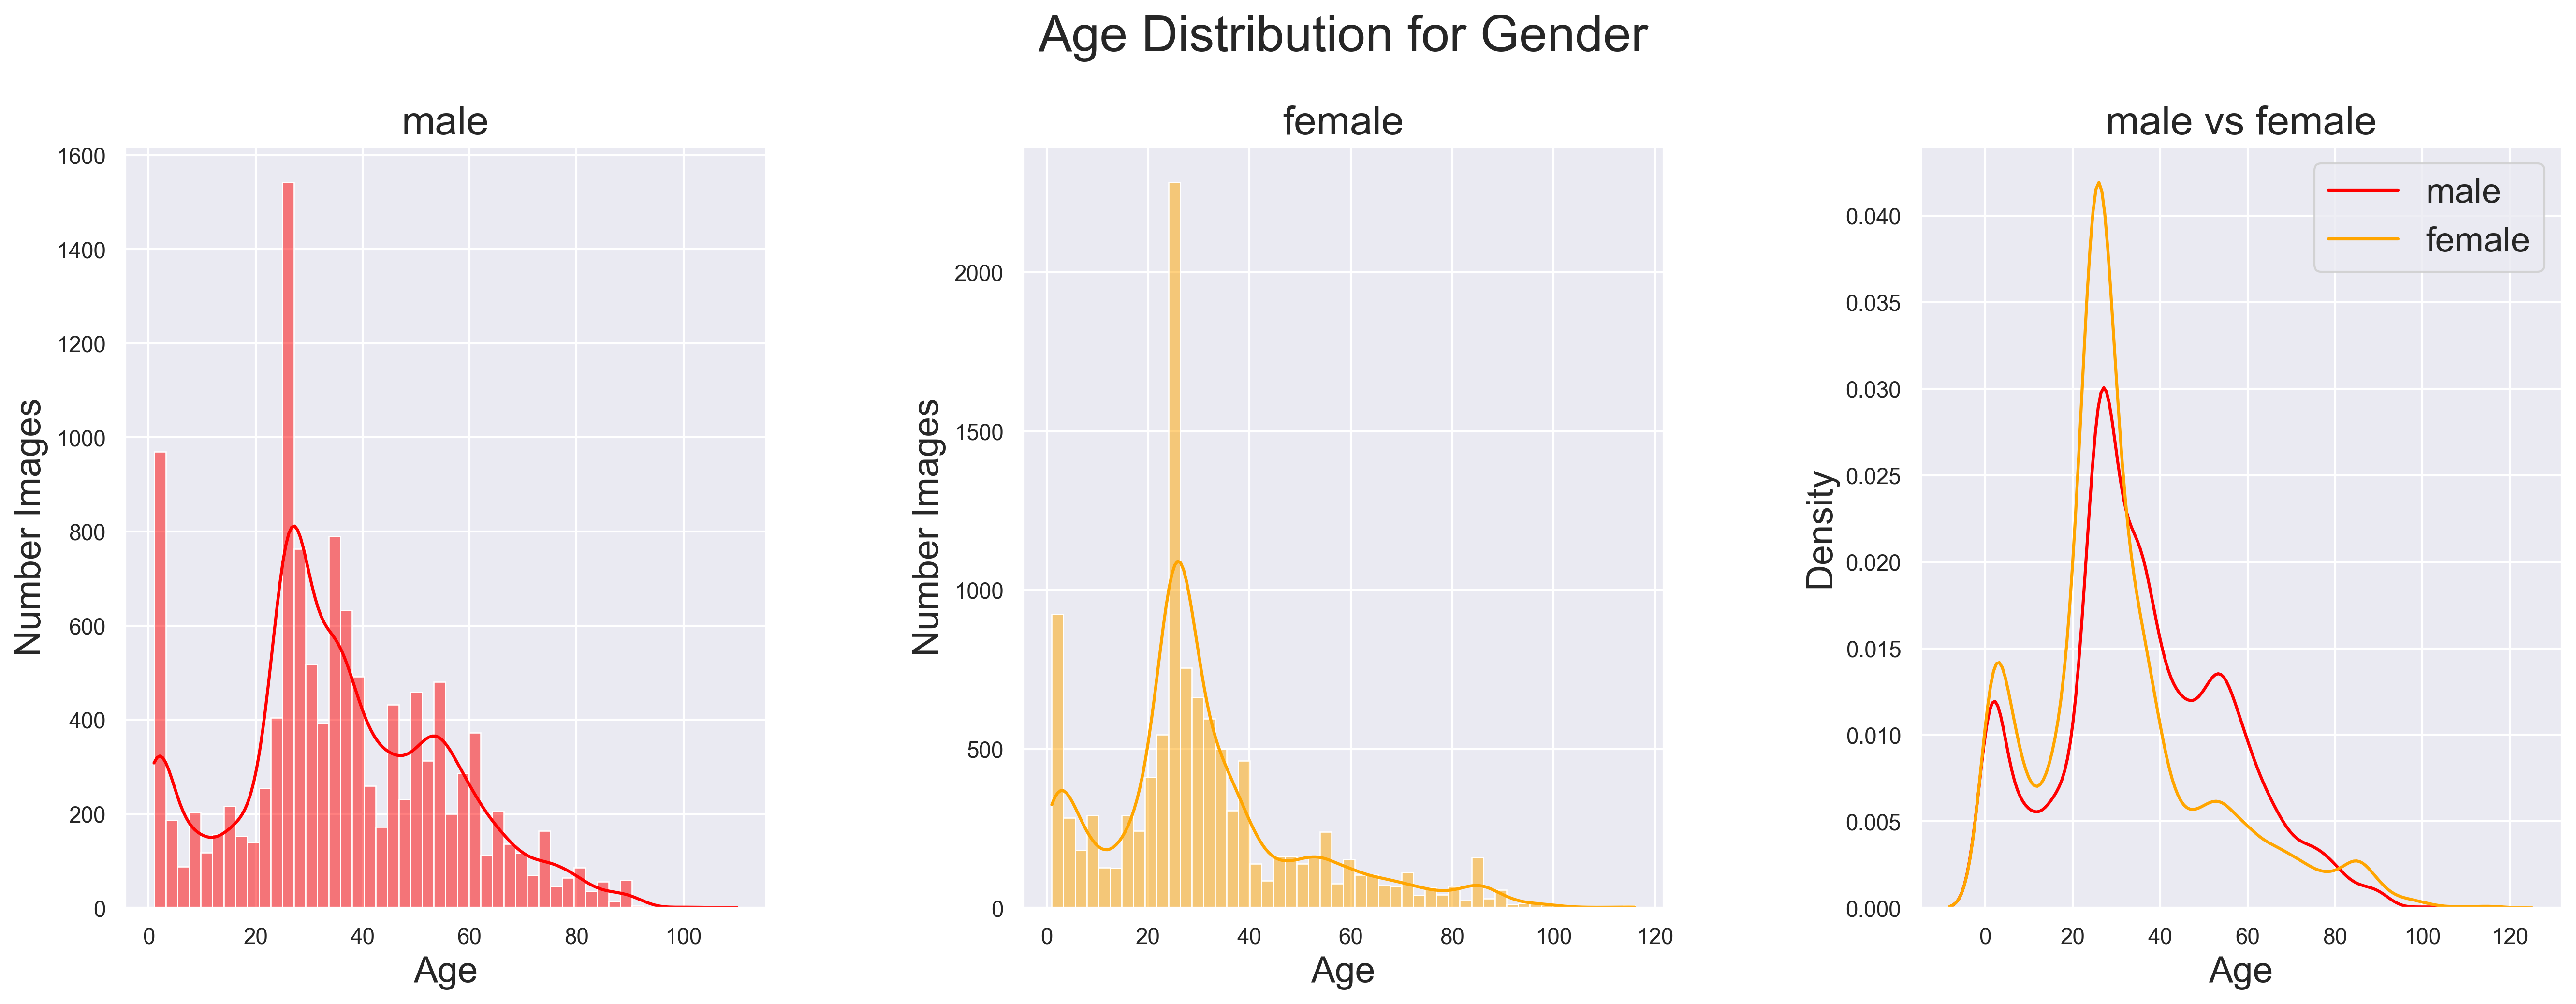

In [6]:
sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Age Distribution for Gender', fontsize=25)
sns.set(font_scale = 1.2)

df_age_male = df.groupby('gender').get_group("male")
df_age_female = df.groupby('gender').get_group("female")
h = sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
h = sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
ax1.set_title("male", fontdict = {'fontsize': 20})
ax2.set_title("female", fontdict = {'fontsize': 20})

sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
h = sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.set_title("male vs female", fontdict = {'fontsize': 20})
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Density", fontsize=18)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)
plt.savefig(SAVE_PATH + "utkface_age_gender_distribution.png", bbox_inches='tight')
plt.show()

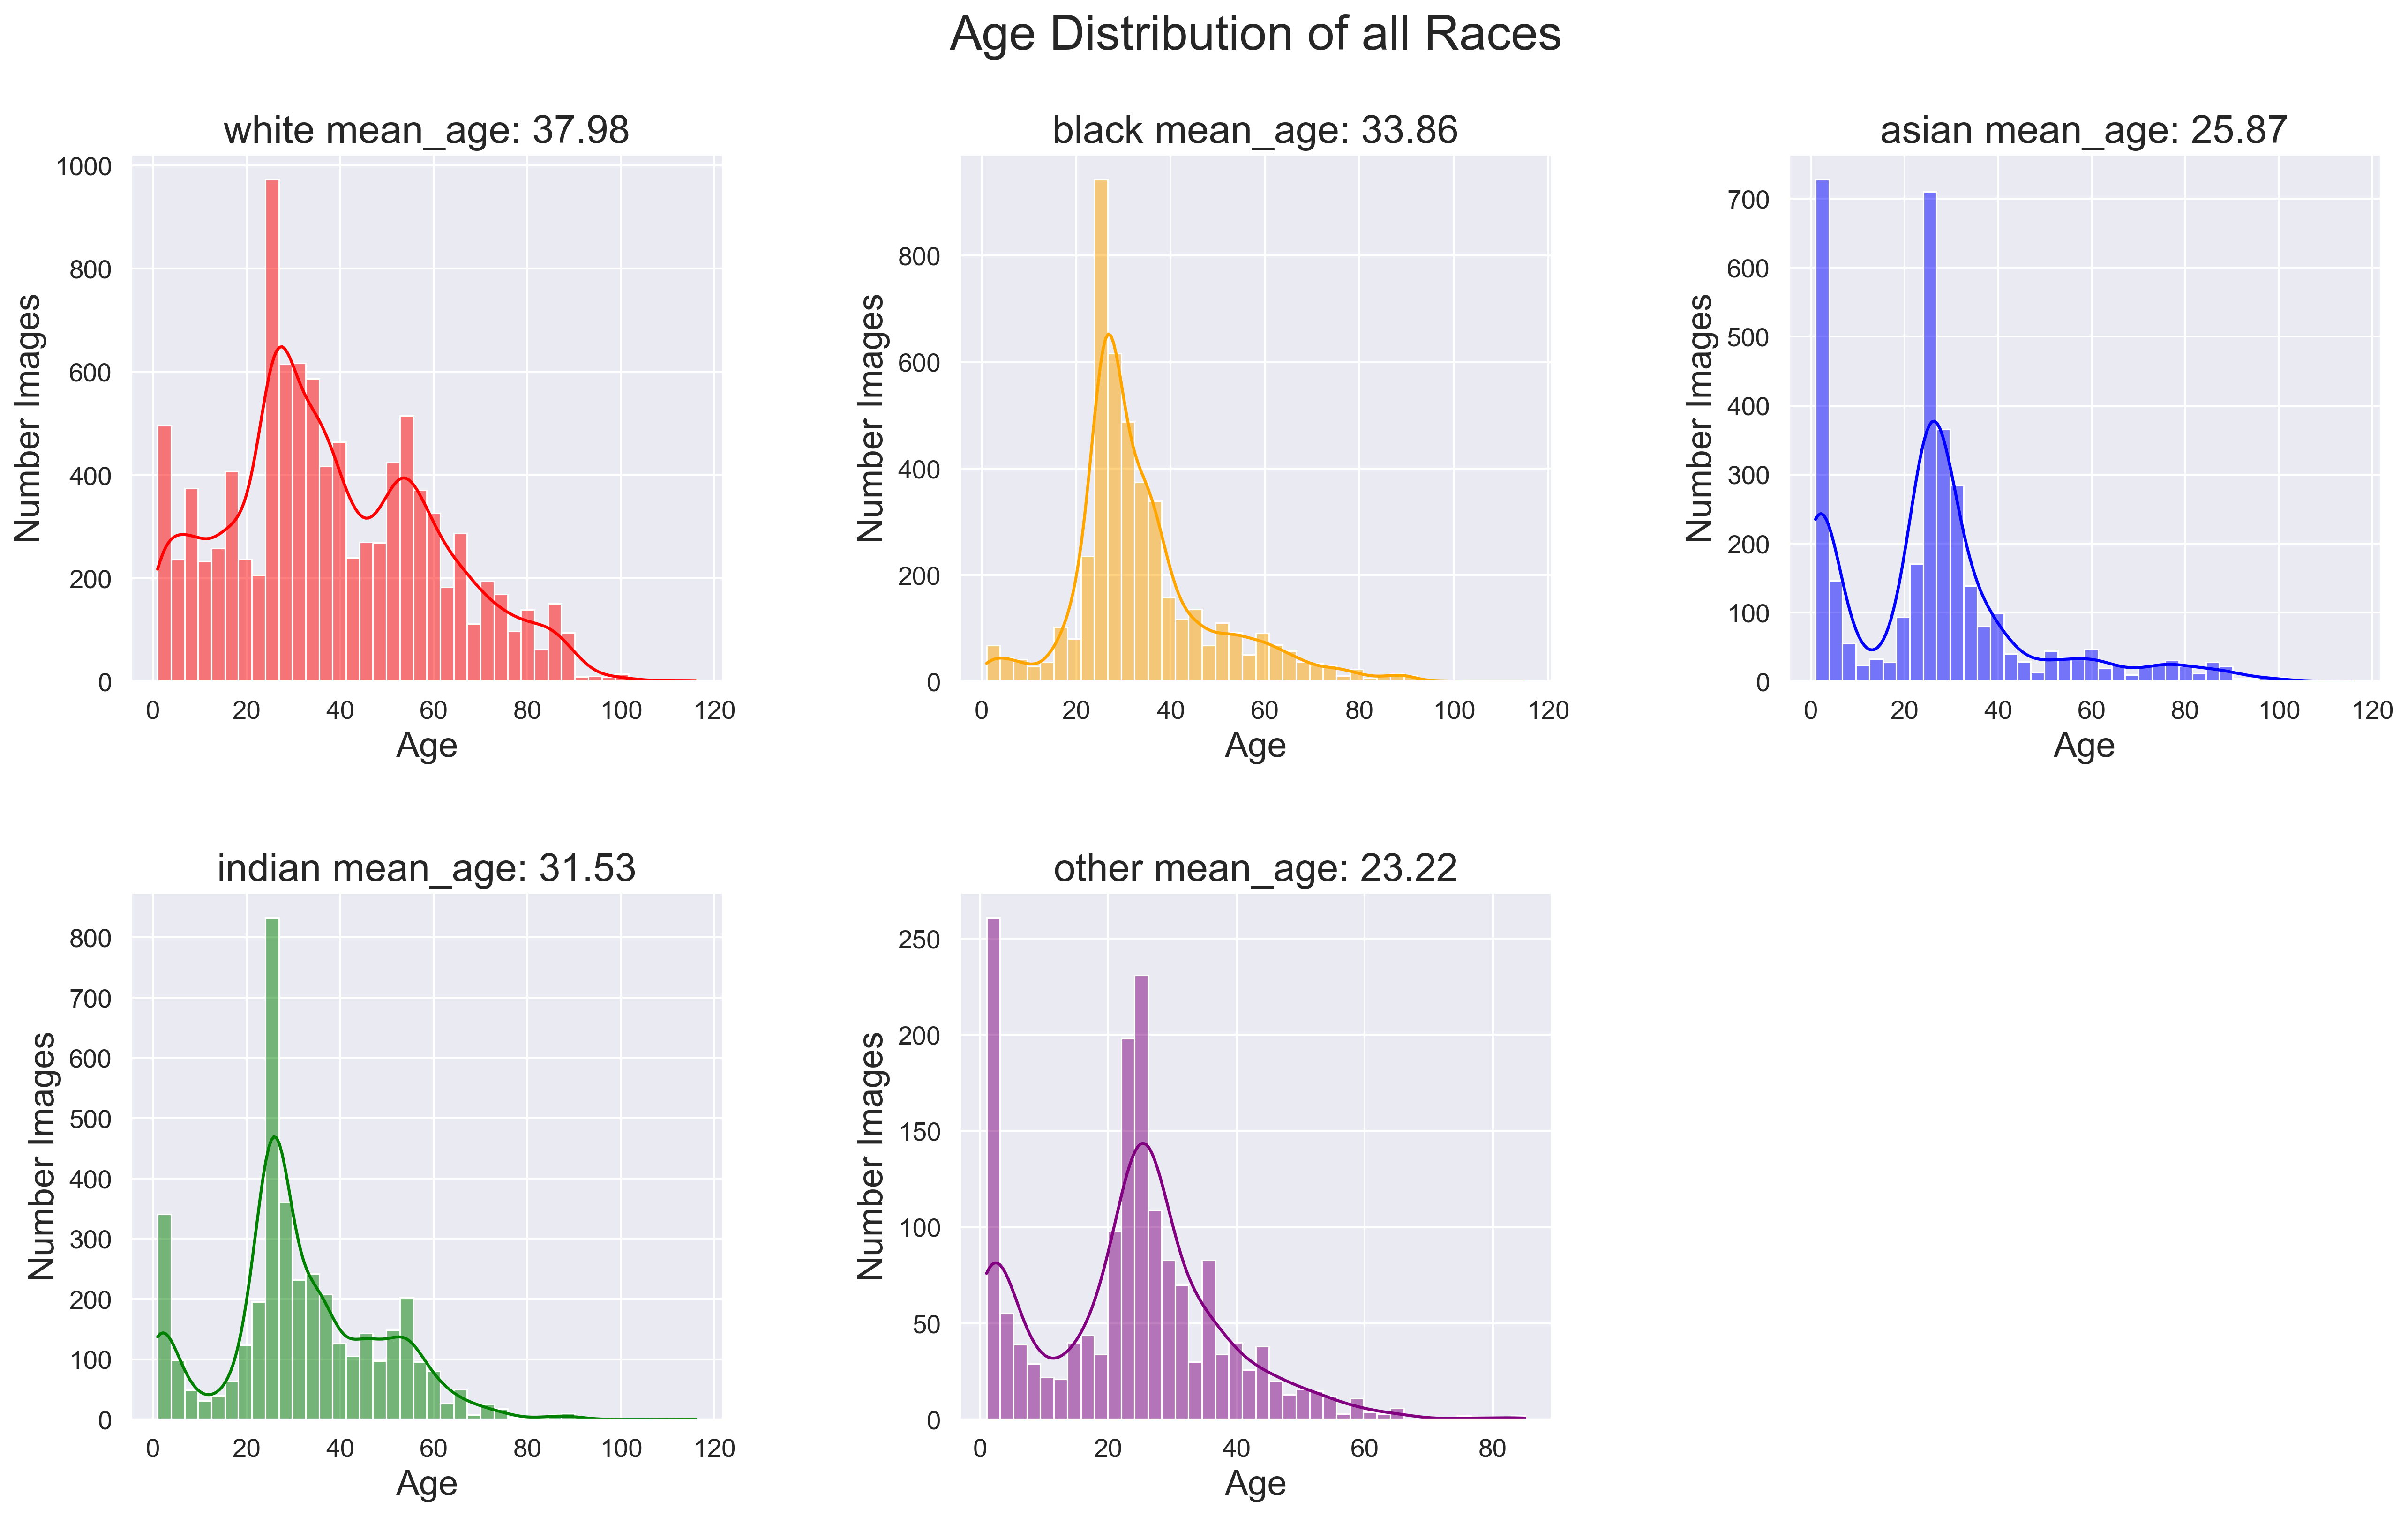

In [7]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Age Distribution of all Races', fontsize=25, y=1.1)
fig.tight_layout()
sns.set(font_scale = 1.2)


plt.subplot(2, 3, 1)
df_race_white = df.groupby('race').get_group("White")
h = sns.histplot(data=df_race_white, x="age", kde=True, color="red", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("white mean_age: "+"%.2f" % df_race_white.mean()["age"], fontsize=20)

plt.subplot(2, 3, 2)
df_race_black = df.groupby('race').get_group("Black")
h = sns.histplot(data=df_race_black, x="age", kde=True, color="orange", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("black mean_age: "+"%.2f" % df_race_black.mean()["age"], fontsize=20)

plt.subplot(2, 3, 3)
df_race_asian = df.groupby('race').get_group("Asian")
h = sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("asian mean_age: "+"%.2f" % df_race_asian.mean()["age"], fontsize=20)

plt.subplot(2, 3, 4)
df_race_indian = df.groupby('race').get_group("Indian")
h = sns.histplot(data=df_race_indian, x="age", kde=True, color="green", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("indian mean_age: "+"%.2f" % df_race_indian.mean()["age"], fontsize=20)

plt.subplot(2, 3, 5)
df_race_other = df.groupby('race').get_group("Others")
h = sns.histplot(data=df_race_other, x="age", kde=True, color="purple", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("other mean_age: "+"%.2f" % df_race_other.mean()["age"], fontsize=20)




plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.savefig(SAVE_PATH + "utkface_age_race_distribution.png", bbox_inches='tight')
plt.show()